In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings
import expt_settings.configs
import importlib
import data_formatters
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
importlib.reload(expt_settings)
importlib.reload(data_formatters)

<module 'data_formatters' from '/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/data_formatters/__init__.py'>

In [5]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('tft_v6', 'outputs')

data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('m4'))
data_csv_path = "./tft_v6/step2_v6_20210301_20210419_sub.csv"
#data_csv_path = '/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/tft/tft_outputs/data/electricity/hourly_electricity.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
print(raw_data.shape)
start = time.time()
# ..., ..., 47, 
train, valid, test = data_formatter.split_data(raw_data, valid_boundary=44, test_boundary=47, his_days=21, pred_days=3)
#train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

print(time.time()-start)


*** Training from defined parameters for m4 ***
Loading & splitting data...
(100000, 43)
Formatting train-valid-test splits.
Setting scalers with training data...
train:(94000, 43), valid:(48000, 43), test:(48000, 43)
read_inputs: ['biz_sale_qty', 'traffic_index', 'day_of_week', 'day_temperature', 'qpf', 'promos_discount', 'sell_price']
categorical_inputs: ['city_id', 'poi_id', 'base_sku_id', 'category1_id', 'category2_id', 'category3_id', 'category4_id', 'is_weekend', 'is_holiday', 'icon_day_type', 'day_icon_id', 'is_seckill']
read_inputs: ['biz_sale_qty', 'traffic_index', 'day_of_week', 'day_temperature', 'qpf', 'promos_discount', 'sell_price']
categorical_inputs: ['city_id', 'poi_id', 'base_sku_id', 'category1_id', 'category2_id', 'category3_id', 'category4_id', 'is_weekend', 'is_holiday', 'icon_day_type', 'day_icon_id', 'is_seckill']
read_inputs: ['biz_sale_qty', 'traffic_index', 'day_of_week', 'day_temperature', 'qpf', 'promos_discount', 'sell_price']
categorical_inputs: ['city_id

In [6]:
#test_merge["base_sku_id_verse"] = data_formatter._cat_scalers["base_sku_id"].inverse_transform(test_merge["base_sku_id_y"])


In [7]:
#test_merge["poi_id_verse"] = data_formatter._cat_scalers["poi_id"].inverse_transform(test_merge["poi_id_y"])


In [8]:
#test_merge[["poi_id_x", "base_sku_id_x", "poi_sku_id", "poi_id_y", "base_sku_id_y", "poi_id_verse", "base_sku_id_verse"]]

In [9]:
for idx, sg in raw_data.groupby("poi_sku_id"):
    s = sg.shape[0]
    time_idx_min, time_idx_max = sg["time_idx"].min(), sg["time_idx"].max()
    if s != 50:
        print(idx, s, time_idx_min, time_idx_max)

In [10]:
# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# fixed_params['minibatch_size'] = 64
# fixed_params['category_count'] = [6]
device = fixed_params['device']
fixed_params['quantiles'] = [0.5]

# with open('data_formatter_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)

In [11]:
fixed_params

{'total_time_steps': 24,
 'num_encoder_steps': 21,
 'num_epochs': 100,
 'early_stopping_patience': 5,
 'multiprocessing_workers': 5,
 'column_definition': [('poi_sku_id',
   <DataTypes.CATEGORICAL: 1>,
   <InputTypes.ID: 4>),
  ('time_idx', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>),
  ('biz_sale_qty', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('traffic_index', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('day_temperature', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('qpf', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('promos_discount', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('city_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('poi_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('base_sku_id', <DataTypes.CATEG

In [12]:
max_samples = 128  # * 200 * 2

elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

# with open('ts_dataset_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(elect, output, pickle.HIGHEST_PROTOCOL)

# with open('ts_dataset_m4.pkl', 'rb') as input:
#     elect = pickle.load(input)

Getting valid sampling locations.
# available segments=48000
Extracting 128 samples...
total time used: 0.21757173538208008


In [13]:
loader = DataLoader(
            elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=False
        )

In [14]:
importlib.reload(tft_model)
model = tft_model.TFT(fixed_params).to(device)

{'total_time_steps': 24, 'num_encoder_steps': 21, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('poi_sku_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('time_idx', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('biz_sale_qty', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('traffic_index', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_temperature', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('qpf', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('promos_discount', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('city_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('poi_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('base_sku_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_IN

In [15]:
from losses.quantile_loss import QuantileLoss
from losses.smape_loss import SMAPELoss
from losses.rmsse_loss import RMSSELoss
from losses.pinball_loss import PinballLoss


q_loss_func = RMSSELoss(fixed_params['device'])
# q_loss_func = SMAPELoss(fixed_params['device'])
# q_loss_func = QuantileLoss(fixed_params['quantiles'])
# import sys
# sys.path.append('/home/arda/Desktop/thesis/')
# from loss_modules import PinballLoss
q_loss_func = PinballLoss(0.45, device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
model.train()
epochs=10
losses = []
for i in range(epochs):
    epoch_loss = []
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    for batch_num, batch in progress_bar:
        optimizer.zero_grad()
        output, all_inputs, attention_components = model(batch['inputs'])
#         loss= q_loss_func(output[:,:,:].view(-1,1), batch['outputs'][:,:,0].flatten().float().to(device))
        loss = q_loss_func(output.squeeze(2), batch['outputs'][:,:,0].float().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_params['max_gradient_norm'])
        optimizer.step()
        epoch_loss.append(loss.item())
    
    losses.append(np.mean(epoch_loss))
    if loss.item() <= min(losses):
        torch.save(model.state_dict(), 'electricity_best_model_smape_loss.pth')
        
    print(np.mean(epoch_loss))
    

  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/layers/scaled_dot_product_attention.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mmask = (-1e+9) * (1. - torch.tensor(mask, dtype=torch.float).to(self.device)) # setting to infinity
 50%|█████     | 1/2 [00:00<00:00,  1.01it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

1.1199956238269806



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.05it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

0.9031932950019836



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.08it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

0.7529999315738678



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

0.7266390323638916



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.17it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

0.7152435183525085



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.21it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

0.6861762404441833



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.16it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

0.6767158508300781



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

0.6276958584785461



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.21it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

0.640694797039032



  0%|          | 0/2 [00:00<?, ?it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


 50%|█████     | 1/2 [00:00<00:00,  1.16it/s]

all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

0.6228189170360565


In [17]:
## 获得city_id, poi_id, base_sku_id的下标

from data_formatters.base import InputTypes
column_definition = fixed_params['column_definition']
input_cols = [
    tup[0]
    for tup in column_definition
    if tup[2] not in {InputTypes.ID, InputTypes.TIME}
]


In [18]:
input_cols

['biz_sale_qty',
 'traffic_index',
 'day_of_week',
 'day_temperature',
 'qpf',
 'promos_discount',
 'sell_price',
 'city_id',
 'poi_id',
 'base_sku_id',
 'category1_id',
 'category2_id',
 'category3_id',
 'category4_id',
 'is_weekend',
 'is_holiday',
 'icon_day_type',
 'day_icon_id',
 'is_seckill']

In [19]:
city_id_idx = input_cols.index("city_id")
poi_id_idx = input_cols.index("poi_id")
base_sku_id_idx = input_cols.index("base_sku_id")
#poi_sku_id_idx = input_cols.index("poi_sku_id")

In [20]:
city_id_idx, poi_id_idx, base_sku_id_idx

(7, 8, 9)

In [21]:
data_formatter._cat_scalers["city_id"]

LabelEncoder()

In [22]:
max_samples = 1000
test_elect = ts_dataset.TSDataset(fixed_params, max_samples, test)
loader = DataLoader(
        test_elect,
        batch_size=fixed_params['minibatch_size'],
        num_workers=0,
        shuffle=False
    )

Getting valid sampling locations.
# available segments=2000
Extracting 1000 samples...
1000 of 1000 samples done..., 1.3300468921661377
total time used: 1.3315188884735107


In [46]:
max_samples = 1000
test_elect = ts_dataset.TSDataset(fixed_params, max_samples, test)
loader = DataLoader(
        test_elect,
        batch_size=fixed_params['minibatch_size'],
        num_workers=0,
        shuffle=False
    )

dfs = []
labels = []
info_dfs = []
time_idxs = []
time_idx_dfs = []
#total_infos = []

from datetime import datetime, timedelta
start_time = datetime.strptime("20210301", "%Y%m%d")
transorm_dt = lambda x: (start_time + timedelta(days=x-1)).strftime("%Y%m%d")

for batch in loader:
    test_outputs = batch["outputs"]
    test_inputs = batch["inputs"]
    test_times = batch["time"]
    output, all_inputs, attention_components = model(batch["inputs"])
    
    city_id_tensor = test_inputs[:, :, city_id_idx]
    poi_id_tensor = test_inputs[:, :, poi_id_idx]
    base_sku_id_tensor = test_inputs[:, :, base_sku_id_idx]
    
    flat_prediction = pd.DataFrame(
        output.detach().cpu().numpy()[:, :, 0],
        columns=[
          'pred_{}'.format(i)
          for i in range(output.shape[1])
    ])
    
    flat_label = pd.DataFrame(
        test_outputs.detach().cpu().numpy()[:, :, 0],
        columns=[
          'label_{}'.format(i)
          for i in range(output.shape[1])
    ])
    
    cols = list(flat_prediction.columns)
    identifier = batch['identifier'][0][0].detach().cpu().numpy()
    # flat_prediction['forecast_time'] = batch['time'][:, 54 - 1, 0]
    flat_prediction['identifier'] = identifier.copy()
    flat_label['identifier'] = identifier.copy()
    
    # 预测值和实际值
    dfs.append(flat_prediction)
    labels.append(flat_label)
    
    # 基础信息
    city_id_values = data_formatter._cat_scalers["city_id"].inverse_transform(city_id_tensor[:, 0].numpy().astype(int))
    #city_id_tensors.append(city_id_values)
    poi_id_values = data_formatter._cat_scalers["poi_id"].inverse_transform(poi_id_tensor[:, 0].numpy().astype(int))
    #poi_id_tensors.append(poi_id_values)
    sku_id_values = data_formatter._cat_scalers["base_sku_id"].inverse_transform(base_sku_id_tensor[:, 0].numpy().astype(int))

    info_df = pd.DataFrame({"city_id": city_id_values,
                           "poi_id": poi_id_values,
                           "base_sku_id": sku_id_values,
                            "identifier": identifier,
                           })
    info_dfs.append(info_df)
    
    # 时间time idx
    time_idxs.append(test_times[-output.shape[1]:])
    time_idx = test_times[-output.shape[1]:]
    time_idx_df = pd.DataFrame()
    for i in range(output.shape[1]):
        time_idx_tensor = time_idx[i][0] ## tensor
        time_idx_df["time_idx_{}".format(i)] = [transorm_dt(int(t)) for t in time_idx_tensor.numpy()]
    time_idx_df["identifier"] = identifier
    time_idx_dfs.append(time_idx_df)

    #total_infos.append(pd.concat([info_df, time_idx_df, flat_prediction, flat_label], axis=1))
    

Getting valid sampling locations.
# available segments=2000
Extracting 1000 samples...
1000 of 1000 samples done..., 1.1801609992980957
total time used: 1.1817090511322021
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/layers/scaled_dot_product_attention.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mmask = (-1e+9) * (1. - torch.tensor(mask, dtype=torch.float).to(self.device)) # setting to infinity


all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_input

In [47]:
all_predictions = pd.concat(dfs, ignore_index=True)
all_labels = pd.concat(labels, ignore_index=True)
all_info_dfs = pd.concat(info_dfs, ignore_index=True)
time_idx_dfs = pd.concat(time_idx_dfs, ignore_index=True)

In [48]:
all_info_dfs

,city_id,poi_id,base_sku_id,identifier
0,4,10000089,76311,86311089
1,2,81,62602,62602081
2,4,10000089,56367,66367089
3,2,122,57602,57602122
4,7,300,75116,75116300
...,...,...,...,...
995,1,1550,89564,89565550
996,1,10000040,19598,29598040
997,7,10000100,10546,20546100
998,7,10000055,93105,103105055


In [49]:
all_predictions.shape, all_labels.shape, all_info_dfs.shape, time_idx_dfs.shape

((1000, 4), (1000, 4), (1000, 4), (1000, 4))

In [50]:
all_predictions_verse = data_formatter.format_predictions(all_predictions)
all_labels_verse = data_formatter.format_predictions(all_labels)

In [51]:
total_pred_info = pd.concat([all_info_dfs, time_idx_dfs, 
                             all_predictions_verse.iloc[:, 0:3], 
                             all_labels_verse.iloc[:, 0:3]], axis=1)

In [52]:
total_pred_info

,city_id,poi_id,base_sku_id,identifier,time_idx_0,time_idx_1,time_idx_2,identifier,pred_0,pred_1,pred_2,label_0,label_1,label_2
0,4,10000089,76311,86311089,20210417,20210418,20210419,86311089,9.867212,8.444923,4.796382,4.0,4.0,1.0
1,2,81,62602,62602081,20210417,20210418,20210419,62602081,3.340526,4.366675,2.075461,3.0,5.0,1.0
2,4,10000089,56367,66367089,20210417,20210418,20210419,66367089,1.345521,1.053598,-0.013878,0.0,1.0,1.0
3,2,122,57602,57602122,20210417,20210418,20210419,57602122,24.635498,25.166071,21.818745,64.0,43.0,29.0
4,7,300,75116,75116300,20210417,20210418,20210419,75116300,16.607645,16.532753,12.784353,13.6,10.3,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1550,89564,89565550,20210417,20210418,20210419,89565550,8.141788,6.254527,5.585021,3.3,5.8,3.0
996,1,10000040,19598,29598040,20210417,20210418,20210419,29598040,2.410544,2.028471,1.365437,1.0,4.0,2.0
997,7,10000100,10546,20546100,20210417,20210418,20210419,20546100,0.348495,0.343661,-0.000046,0.0,0.0,0.0
998,7,10000055,93105,103105055,20210417,20210418,20210419,103105055,7.309348,6.915738,3.530578,4.0,4.0,2.0


In [ ]:
## xgb pred
xgb_file = ""

In [54]:
from pandas import Series
def calc_eval_new(pred, label):
    # 新指标的计算明显比旧指标更利于看指标
    import math
    import copy
    
    label_new = label.copy()
    label_new[label_new < 1] = 1
    err = pred - label
    sq_err = err * err
    
    mae = err.abs().mean()
    mse = math.sqrt(sq_err.mean())
    mape = (err.abs() / label_new).mean()
    dar = (err.abs() <= label_new * 0.2).mean()
    bigger = (err > 0.2 * label_new).mean()
    smaller = (err < -0.2 * label_new).mean()
    
    return mae, mse, mape, dar, smaller, bigger

pred = total_pred_info["pred_2"]
label = total_pred_info["label_2"]
print("shape:", label.shape)
#label = Series(total_labels[:,2,0].detach().numpy())
#pred = Series(output[:,2,0].detach().cpu().numpy())
#label = Series(batch['outputs'][:,2,0].detach().cpu().numpy())
mae, mse, mape, dar, smaller, bigger = calc_eval_new(pred, label)
print(",".join(map(str, [mae, mse, mape, dar, smaller, bigger])))

shape: (1000,)
4.5100481185047006,8.124626273966136,0.8540537268994385,0.212,0.366,0.422


In [247]:
len(time_idxs[0]), len(time_idxs[0][2][0])

(3, 64)

In [248]:
time_idxs[0][2][0]

tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [182]:
data_merge = pd.merge(all_labels_verse, all_predictions_verse, on="identifier")

In [184]:
pred3, label3 = data_merge['t+2'], data_merge['d+2']

In [185]:
from pandas import Series
def calc_eval_new(pred, label):
    # 新指标的计算明显比旧指标更利于看指标
    import math
    import copy
    
    label_new = label.copy()
    label_new[label_new < 1] = 1
    err = pred - label
    sq_err = err * err
    
    mae = err.abs().mean()
    mse = math.sqrt(sq_err.mean())
    mape = (err.abs() / label_new).mean()
    dar = (err.abs() <= label_new * 0.2).mean()
    bigger = (err > 0.2 * label_new).mean()
    smaller = (err < -0.2 * label_new).mean()
    
    return mae, mse, mape, dar, smaller, bigger

mae, mse, mape, dar, smaller, bigger = calc_eval_new(pred3, label3)
print(",".join(map(str, [mae, mse, mape, dar, smaller, bigger])))

4.3996639892701594,7.983418255594016,0.9211975951507262,0.232,0.31,0.458


In [187]:
def extract_poi_sku(x):
    poi_id = x % 1000
    base_sku_id = 
    
data_merge["identifier"].apply(lambda x: extract_poi_sku(x))

,d+0,d+1,d+2,identifier,t+0,t+1,t+2
0,4.500000e+01,2.300000e+01,1.000000e+01,413104,25.994993,20.218733,26.200035
1,2.000000e+01,3.000000e+00,4.300000e+01,413218,20.030603,22.427240,12.432266
2,3.200000e+01,2.320000e+01,1.790000e+01,509119,37.159157,15.062928,13.101579
3,2.000000e+00,0.000000e+00,1.000000e+00,808255,0.960247,1.203756,1.216402
4,1.000000e+00,0.000000e+00,0.000000e+00,808738,0.721068,0.128800,0.931829
...,...,...,...,...,...,...,...
995,-1.387779e-17,-1.387779e-17,-1.387779e-17,113753019,-0.047956,-0.053987,-0.120222
996,4.000000e+00,1.000000e+00,2.000000e+00,113768115,2.461504,2.112512,1.728579
997,4.000000e+00,4.000000e+00,1.000000e+00,114069023,10.472158,7.217155,22.809372
998,2.000000e+00,1.000000e+00,2.000000e+00,114069136,4.228868,4.408438,1.915410


In [125]:
def eval_test():
    max_samples = 1000
    test_elect = ts_dataset.TSDataset(fixed_params, max_samples, test)
    loader = DataLoader(
            test_elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=False
        )
    
    total_outputs = []
    total_ids = []
    total_times = []
    total_labels = []
    for batch in loader:
        test_inputs = batch["inputs"]
        test_outputs = batch["outputs"]
        active_entries = batch["active_entries"]
        time = batch["time"]
        identifier = batch["identifier"]
        
        output, all_inputs, attention_components = model(test_inputs)
        
        total_labels.append(test_outputs)
        total_outputs.append(output)
        total_ids.append(identifier)
        total_times.append(time)
    return total_ids, total_times, total_outputs, total_labels

In [126]:
total_ids, total_times, total_outputs, total_labels = eval_test()

Getting valid sampling locations.
# available segments=2000
Extracting 1000 samples...
1000 of 1000 samples done...
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])


/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/layers/scaled_dot_product_attention.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mmask = (-1e+9) * (1. - torch.tensor(mask, dtype=torch.float).to(self.device)) # setting to infinity


all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_inputs:None, known_combined_layer:torch.Size([64, 24, 160, 11]), obs_inputs:torch.Size([64, 24, 160, 1]), static_inputs:torch.Size([64, 7, 160])
all_inputs:torch.Size([64, 24, 19]), unknown_input

In [128]:
total_outputs = torch.cat(total_outputs, dim = 0)
total_labels = torch.cat(total_labels, dim = 0)

In [139]:
total_outputs.shape, total_labels.shape

(torch.Size([1000, 3, 1]), torch.Size([1000, 3, 1]))

In [123]:
test_inputs[0].shape, test_outputs[0].shape

(torch.Size([24, 19]), torch.Size([3, 1]))

In [114]:
all_predictions = pd.concat(dfs)


In [116]:
all_predictions_unnormalized = data_formatter.format_predictions(all_predictions)

In [117]:
all_predictions_unnormalized

,t+0,t+1,t+2,identifier
1,1.447912,0.604474,0.420541,108073
1,1.447912,0.604474,0.420541,108073
2,25.293655,20.793457,26.033073,413104
2,25.293655,20.793457,26.033073,413104
56,3.147585,6.375054,2.659672,420314
...,...,...,...,...
12,3.159654,2.049625,1.684893,114426028
11,6.575827,8.866814,5.264314,114481117
11,6.575827,8.866814,5.264314,114481117
26,7.068996,5.720604,5.754289,114483086


In [118]:
all_predictions

,t+0,t+1,t+2,identifier
0,-0.358150,0.708421,-0.209241,1652849
1,0.059971,-0.201864,-0.611625,75892085
2,0.042736,-0.159291,-0.698141,1652187
3,0.753680,-0.578848,-0.177355,93159251
4,-2.168302,-0.788183,-0.758809,108681072
...,...,...,...,...
35,-0.189255,1.650724,-0.228383,102980315
36,0.894870,1.424569,0.231653,98612022
37,0.279898,0.039603,-0.398327,75439125
38,-0.267423,-0.311166,-0.676533,75823231


In [65]:
len(test_ids[0]), test_outputs[0].shape, test_labels[0].shape

(24, torch.Size([64, 3, 1]), torch.Size([64, 3, 1]))

In [73]:
test_ids[0][0][0].shape

torch.Size([64])

In [74]:
test_elect = ts_dataset.TSDataset(fixed_params, max_samples, test)

Getting valid sampling locations.
# available segments=2000
Extracting 128 samples...


In [75]:
t1 = next(iter(test_elect))

In [76]:
t1.keys()

dict_keys(['inputs', 'outputs', 'active_entries', 'time', 'identifier'])

In [78]:
len(t1["identifier"])

24

In [93]:
model.input_size

19

In [79]:
t1["inputs"].shape

(24, 19)

In [89]:
t1["inputs"]

array([[-2.61499933e-01,  6.53720450e-02,  1.06903718e+00,
        -2.00897061e+00, -2.10058102e-01, -3.45032780e-01,
        -3.06877460e-01,  4.00000000e+00,  2.43000000e+02,
         5.47000000e+02,  0.00000000e+00,  9.00000000e+00,
         1.00000000e+00,  1.60000000e+01,  1.00000000e+00,
         0.00000000e+00,  2.00000000e+00,  8.00000000e+00,
         0.00000000e+00],
       [ 1.25584536e+00,  6.53720450e-02,  1.57655988e+00,
        -1.28543330e+00, -2.10058102e-01, -3.45032780e-01,
        -3.06877460e-01,  4.00000000e+00,  2.43000000e+02,
         5.47000000e+02,  0.00000000e+00,  9.00000000e+00,
         1.00000000e+00,  1.60000000e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  7.00000000e+00,
         0.00000000e+00],
       [ 4.97172712e-01,  6.53720450e-02, -1.46857632e+00,
         7.04294294e-01, -2.10058102e-01,  2.89827535e+00,
         4.21124610e+00,  4.00000000e+00,  2.43000000e+02,
         5.47000000e+02,  0.00000000e+00,  9.00000000e+00,
    

18


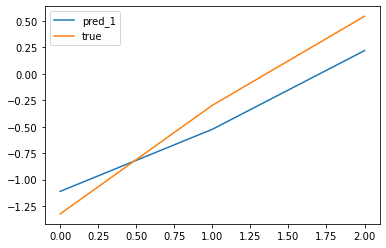

In [60]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [53]:
def symmetric_mean_absolute_percentage_error(forecast, actual):
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    sequence_length = forecast.shape[1]
    sumf = np.sum(np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)), axis=1)
    return np.mean((2 * sumf) / sequence_length)

In [36]:
pred = output[:,:,0].detach().cpu().numpy()
label = batch['outputs'][:,:,0].detach().cpu().numpy()
symmetric_mean_absolute_percentage_error(output[:,:,0].detach().cpu().numpy(),
                                        batch['outputs'][:,:,0].detach().cpu().numpy())



0.6900924920312108

In [132]:
total_outputs.shape, total_labels.shape

AttributeError: 'list' object has no attribute 'shape'

In [136]:
total_outputs.shape, total_labels.shape

AttributeError: 'list' object has no attribute 'shape'

In [146]:
from pandas import Series
def calc_eval_new(pred, label):
    # 新指标的计算明显比旧指标更利于看指标
    import math
    import copy
    
    label_new = label.copy()
    label_new[label_new < 1] = 1
    err = pred - label
    sq_err = err * err
    
    mae = err.abs().mean()
    mse = math.sqrt(sq_err.mean())
    mape = (err.abs() / label_new).mean()
    dar = (err.abs() <= label_new * 0.2).mean()
    bigger = (err > 0.2 * label_new).mean()
    smaller = (err < -0.2 * label_new).mean()
    
    return mae, mse, mape, dar, smaller, bigger

pred = Series(total_outputs[:,2,0].detach().numpy())
label = Series(total_labels[:,2,0].detach().numpy())
#pred = Series(output[:,2,0].detach().cpu().numpy())
#label = Series(batch['outputs'][:,2,0].detach().cpu().numpy())
mae, mse, mape, dar, smaller, bigger = calc_eval_new(pred, label)
print(",".join(map(str, [mae, mse, mape, dar, smaller, bigger])))

0.8502095174471132,1.3009139157395846,0.7050817978703443,0.179,0.374,0.447
